# Tutorial 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
from mithra import *

In [3]:
import importlib
importlib.reload(spec)
importlib.reload(tracks)

<module 'mithra.tracks' from '/Users/nichollsh/Projects/mithra/mithra/tracks.py'>

## Read and plot evolution tracks

In [4]:
# Reads Baraffe+15 evolution tracks from txt file in data folder
tr = tracks.read_bhac()

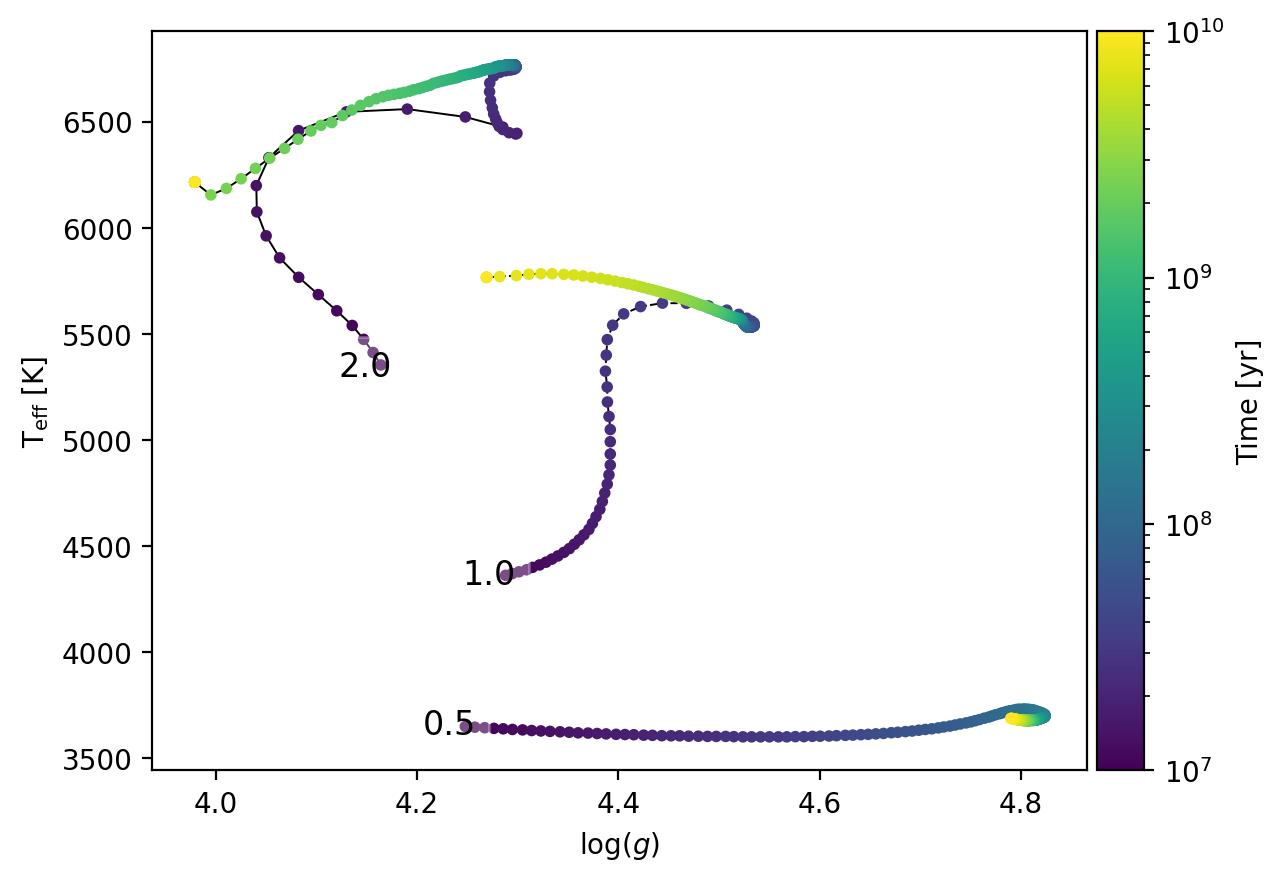

In [5]:
# Timestamps
times = np.logspace(7,10,200)
cmap= plt.cm.viridis
norm = mpl.colors.LogNorm(vmin=times[0], vmax=times[-1]) 
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([])  

# Setup plot
plt.close("all")
fig,ax = plt.subplots(1,1)

# For each mass...
masses = [0.5, 1.0, 2.0]
styles = ["dotted", "dashed", "solid"]
for i in range(len(masses)):
    teffs = []
    loggs = []
    mass = masses[i]
    for age in times:  # For each time, get Teff and logg
        vals = tracks.get_params_bhac(tr, mass, age, ["Teff","logg"])
        teffs.append(vals[0])
        loggs.append(vals[1])
    # Make plot for this mass
    ax.plot(loggs, teffs, color='k', lw=0.7, linestyle=styles[i])
    ax.scatter(loggs, teffs, c=times, cmap=cmap, norm=norm, s=10, zorder=3)
    ax.text(loggs[0]*0.99, teffs[0]*0.99, "%.1f"%mass, backgroundcolor=(1.0, 1.0, 1.0, 0.3), fontsize=12)

# Colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='Time [yr]')  

# Show plot
ax.set(xlabel="log($g$)", ylabel=r"T$_{\text{eff}}$ [K]")
plt.show()

## Get stellar spectrum for a particular mass, age

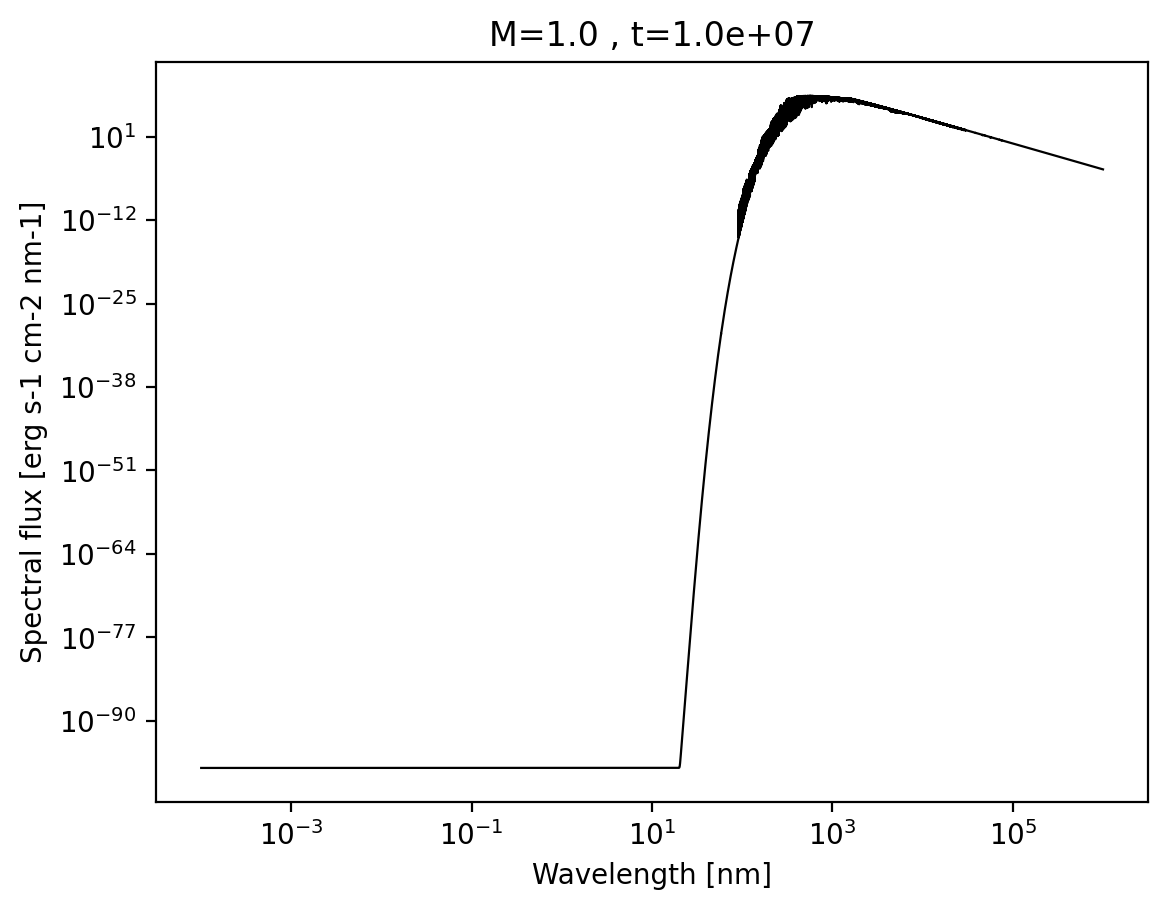

In [6]:
mass = 1.0
age  = 1.0e7

# Get Teff and logg for this stellar mass and age
out = tracks.get_params_bhac(tr, mass, age, ["Teff","logg"])

# Crudely get closest spectrum for this Teff and logg
wl, fl = spec.get_spec_from_npy(out[0], out[1])

# Make plot of spectrum for this time
fig,ax = plt.subplots()
ax.plot(wl,fl, lw=0.8, color='black')
ax.set(xscale="log", yscale="log")
ax.set(xlabel="Wavelength [nm]", ylabel="Spectral flux [erg s-1 cm-2 nm-1]", title="M=%.1f , t=%.1e"%(mass, age))
plt.show()    

# Save data
spec.write_csv("output/test.csv", wl, fl)

## Create interpolated spectral grid 

The interpolated grid has dimensions of `(num_teff, num_logg, num_wave)`. This becomes increasingly expensive with increasing `num_wave` but the choice of the other two parameters does not impact performance. This is because larger values of `num_wave` require including data in order to perform the interpolation.

In [7]:
itp = spec.create_interp(num_teff=70, num_logg=70, num_wave=40, teff_lims=(2e3, 6e3))

Reading npy files...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105ecd8e0>>
Traceback (most recent call last):
  File "/Users/nichollsh/miniconda3/envs/proteus/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


It is possible to store these interpolated points in an Xarray dataset. This can then be saved to (and read from) a single NetCDF file

In [ ]:
# Convert to xarray dataset from interpolated values and save to a NetCDF file
ds = spec.create_dataset(itp)
spec.write_dataset(ds, "output/interp.nc")

In [ ]:
# Check shape of interpolated data
v,x,y,z = itp[0],itp[1],itp[2],itp[3]
sh = np.shape(v)
print(sh)

(70, 70, 40)


2869.5652173913045 3.8043478260869565


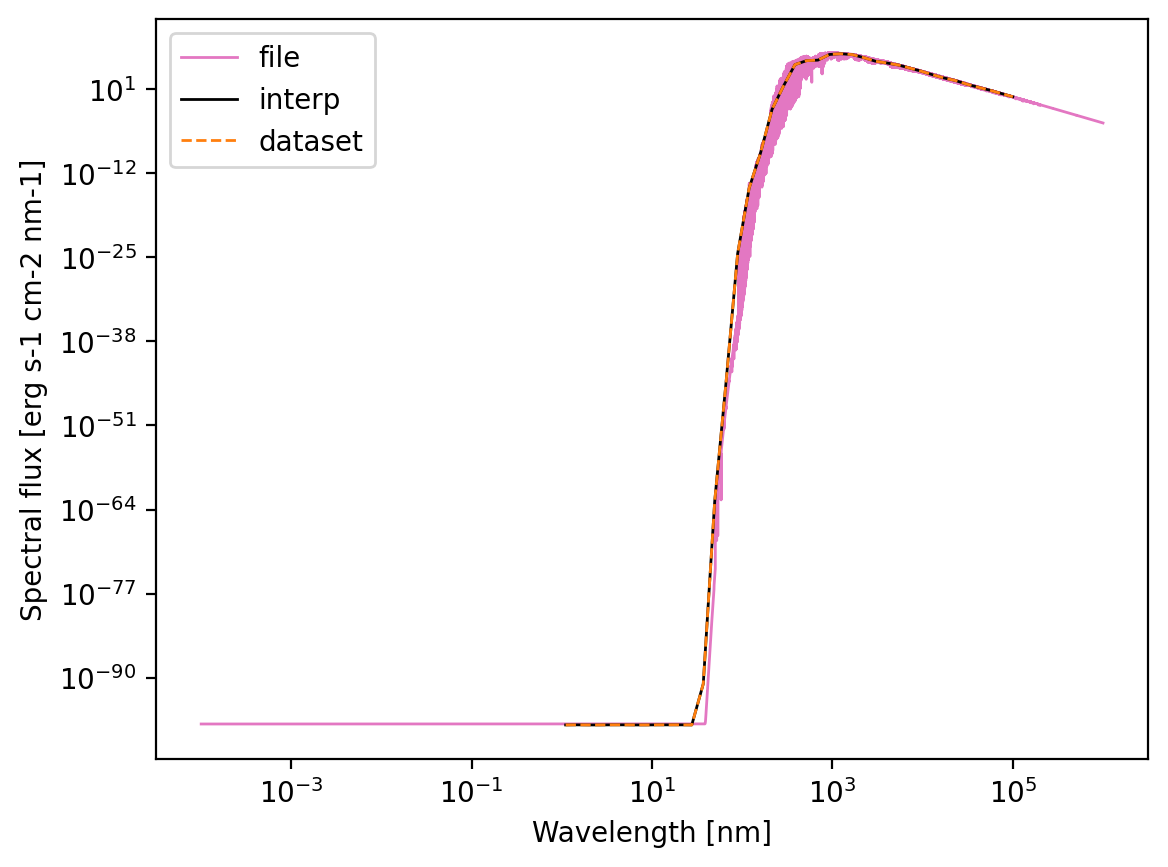

In [ ]:
# Check interpolation for a randomly chosen point (i,j) in the grid
i = 15
j = 30

# Teff and logg for this point
teff = x[i,j,0]
logg = y[i,j,0]
print(teff, logg)

# Init plot
plt.close("all")
fig,ax = plt.subplots(1,1)

# Plot from nearest npy file
wl, fl = spec.get_spec_from_npy(x[i,j,0], y[i,j,0])
ax.plot(wl,fl,label="file", lw=1, color='tab:pink')

# Plot from interpolated arrays
ax.plot(z[i,j,:],v[i,j,:],label="interp",lw=1, color='k')

# Plot from xarray dataset
wl,fl,t,l = spec.get_spec_from_dataset(ds, teff, logg)
ax.plot(wl,fl,label="dataset", lw=1, color='tab:orange' ,linestyle='dashed')

# Show
ax.set(xscale="log",yscale="log", xlabel="Wavelength [nm]", ylabel="Spectral flux [erg s-1 cm-2 nm-1]")
ax.legend()
plt.show()

The pink line shows the full spectrum from the grid. This includes narrow features.    
The black line shows the interpolated spectrum, which broadly looks the same but does not contain as many features because of the reduced resolution of the data.     
The orange line (should) show the same data as the black line, but is stored in a different format.

## Plot spectral evolution for a fixed stellar mass

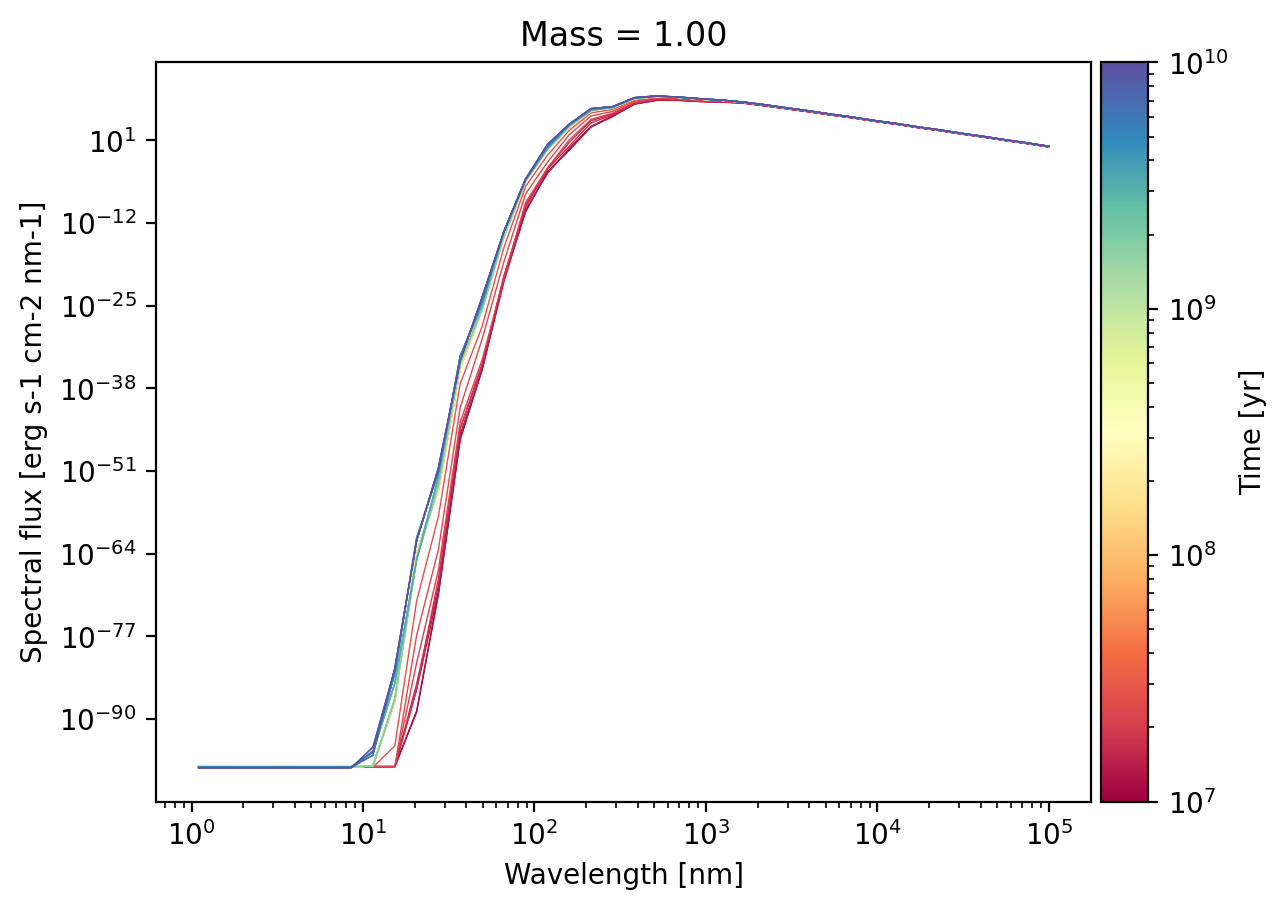

In [ ]:
# Timestamps
tarr = np.logspace(7,10,50)
cmap= plt.cm.Spectral
norm = mpl.colors.LogNorm(vmin=tarr[0], vmax=tarr[-1]) 
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)    
sm.set_array([])  

# Mass of star
mass = 1.0

# Init plot
fig,ax = plt.subplots(1,1)

# For each time...
for time in tarr:

    # Get Teff and logg
    out = tracks.get_params_bhac(tr, mass, time, ["Teff","logg"])
    c = cmap(norm(time))
    
    # Get spectrum from interpolated grid
    w,f,t,l = spec.get_spec_from_dataset(ds,out[0],out[1])
    
    # Plot this spectrum
    ax.plot(w,f, color=c, alpha=1.0, lw=0.5, zorder=3)

# Show plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', label='Time [yr]')  
ax.set(xscale="log", yscale="log")
ax.set(xlabel="Wavelength [nm]", ylabel="Spectral flux [erg s-1 cm-2 nm-1]")
ax.set_title("Mass = %.2f"%mass)
plt.show()